# Understanding the Yolo Algorithm and Fine-Tuning It
____


# Overview of Yolo Algorithm

The YOLO algorithm is designed to preform object detection and image classification. Usually, detection and classification are often two separate models which take two passes, however, yolo combines the two in one pass which is why it's named you only look one. This allows for quick detection and the ability to be used in real time applications.  The following output looks like this:

<img src="cover.png" width="400" height="300">

Yolo does object detection and classification in one pass by dividing the image into an SXS Matrix like the image below:

<img src="SXS.png" width="300" height="300">

Then for each cell two categories of features is created, the first, is on the object detection boxes and the second is classification of each SXS square. The Object Detction is done in the following way. For each rectangle in SXS we take a finite amount of bounding boxes. For example if we take two boxes per rectange we would have to vectors with the following data:

                                    [x, y, sqrt(W), sqrt(H), C]

X, Y are the center coordinates of the bounding box, W and H are the width and height, and C which is a confidence score representing the models confidence that an object actually exists in the bounding box.
Additionally, we have a tensor with the following data 

                                    [P(c1), P(c2), ... P(cn)]

This represents what is the probability that what is in the SXS cell is a given classification. So for each grid, we eventually build a (Bx5+n) matrix where B is the number of bounding boxes and n is the number of classifications in the model. We repeat this process for each cell in the SXS grid until we have a final feature matrix. 

We then use a loss function, which will be explained later in this markdown to compute both how well the bounding boxes are predicting object, how well the model is classified, and how well the combination is doing. 

Because we gather all the data in one pass, yolo can run quite fast. The newest versions run at 45 frames per second while optimized versions can process at 150 frames per second with 25 milliseconds of latency. The best alternative RCNN's most opitmized version runs at about max 17 frames per second. 

In this tutorial, we will teach you how to implement YoloV1, we will then shop how to pull the YoloV8 pre trained off the web and opotimize it for your preferred use. Below are code snipets of indepth walk through of the two areas we believe YOLO is unique from other models: data engineering and the loss function. We then train the model described in the original YOLO paper. Finally, we walk-through an application of YOLO: finetuning the model for street signs to get better performance for applications such as self-driving vehicles! 

## Before We Get Started

We start by importing the necessary packages. Most of the packages we will use are torch modules. We will also use some scikit-image modules, as well as an xml module and a counter from Collections.

In [51]:
import torch
import torch.nn as nn
import pandas as pd
import os
import PIL
import skimage
from skimage import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from torch.utils.data import DataLoader
from tqdm import tqdm
seed = 123
import xml.etree.ElementTree as ET
torch.manual_seed(seed)
from collections import Counter

We also need to define some parameters that will be used throughout YOLO and were mentioned during the introduction above.

grid_size: the original image is divided into a grid with length grid_size  
num_boxes: number of bounding boxes to be predicted in each grid cell  
num_classes: number of classes an object can be identified as  

# Data Engineering

Next, we set our train and test directiories.

In [1]:
files_dir = './archive/train'
test_dir = './archive/test'

Now, we need to build out dataframes for our training and test images. We will need to annotate the images for training purposes. We do this by looping through and creating a new series of `.xml` files of the same name as their `.jpg` counterparts.

In [9]:
### BUILD TRAINING DF
images = [image for image in sorted(os.listdir(files_dir)) if image[-4:]=='.jpg']
annots = []
# build annotations
for image in images:
    annot = image[:-4] + '.xml'
    annots.append(annot)
    
images = pd.Series(images, name='images')
annots = pd.Series(annots, name='annots')
df = pd.concat([images, annots], axis=1)  # Nx2 df where N is num training pictures
df = pd.DataFrame(df)  # training df

print("df Sample:")
print(df.sample(1))
print()

### BUILD TEST DF
test_images = [image for image in sorted(os.listdir(test_dir))
                        if image[-4:]=='.jpg']

test_annots = []
# build test annotations
for image in test_images:
    annot = image[:-4] + '.xml'
    test_annots.append(annot)

test_images = pd.Series(test_images, name='test_images')
test_annots = pd.Series(test_annots, name='test_annots')
test_df = pd.concat([test_images, test_annots], axis=1)  # Nx2 df where N is num test pictures
test_df = pd.DataFrame(test_df)  # test df

print("test_df Sample:")
print(test_df.sample(1))


df Sample:
            images         annots
217  orange_56.jpg  orange_56.xml

test_df Sample:
     test_images   test_annots
10  apple_87.jpg  apple_87.xml


The next step is to build our dataset that we'll use for training. We will use `df` and the `files_dir` to build our `torch` dataset.

In [18]:
class FruitImagesDataset(torch.utils.data.Dataset):
    def __init__(self, df=df, files_dir=files_dir, S=7, B=2, C=3, transform=None):
        self.annotations = df  # use annotated df we made for the Dataset annotations
        self.files_dir = files_dir
        self.transform = transform  # not using a transform
        self.S = S  # grid_size
        self.B = B  # num_boxes
        self.C = C  # num_classes

    # Size of the dataset
    def __len__(self):
        return len(self.annotations) 

    # Get item from an index
    def __getitem__(self, index):
        # get full path
        label_path = os.path.join(self.files_dir, self.annotations.iloc[index, 1])
        boxes = []
        tree = ET.parse(label_path)
        root = tree.getroot()
        
        class_dictionary = {'apple':0, 'banana':1, 'orange':2}

        # build out boxes
        if(int(root.find('size').find('height').text) == 0):
            filename = root.find('filename').text  # retrieve filename
            img = Image.open(self.files_dir + '/' + filename)  # get image
            img_width, img_height = img.size  # get dimensions
            
            for member in root.findall('object'):
                
                klass = member.find('name').text
                klass = class_dictionary[klass]
            
                # bounding box
                xmin = int(member.find('bndbox').find('xmin').text)
                xmax = int(member.find('bndbox').find('xmax').text)
            
                ymin = int(member.find('bndbox').find('ymin').text)
                ymax = int(member.find('bndbox').find('ymax').text)
                
                centerx = ((xmax + xmin) / 2) / img_width
                centery = ((ymax + ymin) / 2) / img_height
                boxwidth = (xmax - xmin) / img_width
                boxheight = (ymax - ymin) / img_height
            
                # build individual box
                boxes.append([klass, centerx, centery, boxwidth, boxheight])
        

        elif(int(root.find('size').find('height').text) != 0):
            
            for member in root.findall('object'):
            
                klass = member.find('name').text
                klass = class_dictionary[klass]
            
                # bounding box
                xmin = int(member.find('bndbox').find('xmin').text)
                xmax = int(member.find('bndbox').find('xmax').text)
                img_width = int(root.find('size').find('width').text)
            
                ymin = int(member.find('bndbox').find('ymin').text)
                ymax = int(member.find('bndbox').find('ymax').text)
                img_height = int(root.find('size').find('height').text)
                
                centerx = ((xmax + xmin) / 2) / img_width
                centery = ((ymax + ymin) / 2) / img_height
                boxwidth = (xmax - xmin) / img_width
                boxheight = (ymax - ymin) / img_height
            
            
                boxes.append([klass, centerx, centery, boxwidth, boxheight])

               
        boxes = torch.tensor(boxes)
        img_path = os.path.join(self.files_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        image = image.convert("RGB")

        # option to use transform
        if self.transform:
            image, boxes = self.transform(image, boxes)

        # convert each box to a cell
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            # i,j represents the cell row and cell column
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            """
            Calculating the width and height of cell of bounding box,
            relative to the cell is done by the following, with
            width as the example:
            
            width_pixels = (width*self.image_width)
            cell_pixels = (self.image_width)
            
            Then to find the width relative to the cell is simply:
            width_pixels/cell_pixels, simplification leads to the
            formulas below.
            """
            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            # If no object already found for specific cell i,j
            # Note: This means we restrict to ONE object
            # per cell!
#             print(i, j)
            if label_matrix[i, j, self.C] == 0:
                # Set that there exists an object
                label_matrix[i, j, self.C] = 1

                # Box coordinates
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 4:8] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

# Loss Function

It's time to build the loss function, which is an acculumation of loss from box coordinates, object detection, and class labeling. We first need to define some metrics and implement the corresponding utility functions that will be used throughout the loss.

### Intersection over Union Utility Function

The intersection over Union metric is used to determine how well the predicted box matches the annotated box label. The function is essentially a ratio where the numerator is the overlap between the predictions and the denominator is the total area of the predictions. As a result, a perfect match would have an IoU score of 1, and worse predictions would have a score less than 1.

In [40]:
def intersection_over_union(boxes_preds, boxes_labels, box_format='midpoint'):
    """
    Calculates intersection over union
    
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes are (x,y,w,h) or (x1,y1,x2,y2) respectively.
    
    Returns:
        tensor: Intersection over union for all examples
    """
    # boxes_preds shape is (N, 4) where N is the number of bboxes
    #boxes_labels shape is (n, 4)
    
    if box_format == 'midpoint':
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
        
    if box_format == 'corners':
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4] # Output tensor should be (N, 1). If we only use 3, we go to (N)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]
    
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)
    
    #.clamp(0) is for the case when they don't intersect. Since when they don't intersect, one of these will be negative so that should become 0
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    
    return intersection / (box1_area + box2_area - intersection + 1e-6)

### Mean Average Precision

Mean Average Precision (mAP) is a metric we use during evaluation. mAP uses a combination of precision and recall to determine how accurately the model correctly predicts objects. The object predictions are determined by whether the Intersection over Union of the predicted box and target box is above a certain threshold.

In [53]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision 
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

### Loss Function for Box Coordinates

Let's start with the first of 4 loss functions: loss for box coordinates. To get this loss, we will follow the below steps:  
1) Calculate the IoUs for each of the 2 (iou_b1 and iou_b2) bounding box predictions for each grid cell.
2) We will then use the best box predictions out of each of the two predictions.
3) Determine which object detections are supposed to exist (exists_box)
4) Take mean-squared error of box coordinate predictions and box coordinate targets

In [55]:
def loss_fn_box_coordinates(predictions, target, num_classes=3):
    
    ## First calculate IoUs for the two bounding box predictions
    iou_b1 = intersection_over_union(predictions[..., num_classes + 1:num_classes + 5], target[..., num_classes + 1:num_classes + 5])
    iou_b2 = intersection_over_union(predictions[..., num_classes + 6:num_classes + 10], target[..., num_classes + 1:num_classes + 5])
    ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

    iou_maxes, bestbox = torch.max(ious, dim=0)
    exists_box = target[..., num_classes].unsqueeze(3)
    print("Exists box", exists_box.shape, exists_box)

    box_predictions = exists_box * (
            (
                bestbox * predictions[..., num_classes + 6:num_classes + 10]
                + (1 - bestbox) * predictions[..., num_classes + 1:num_classes + 5]
            )
        )

    print("Box Predictions", box_predictions.shape, box_predictions)
    box_targets = exists_box * target[..., num_classes + 1:num_classes + 5]

    box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
        torch.abs(box_predictions[..., 2:4] + 1e-6)
    )
    box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

    mse = nn.MSELoss(reduction="sum")
    return mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

### Loss Function for Object Loss

The second loss function is for if the model correctly determines if objects are in bounding boxes when there exists an object in the target data. To do so, we follow a similar process as before to determine bestbox and exists_box. However, for this loss, we take the mean-squared error between whether objects are correctly present in the predictions versus targets.

In [21]:
def loss_fn_object_loss(predictions, target, num_classes=3):

    ## First calculate IoUs for the two bounding box predictions
    iou_b1 = intersection_over_union(predictions[..., num_classes + 1:num_classes + 5], target[..., num_classes + 1:num_classes + 5])
    iou_b2 = intersection_over_union(predictions[..., num_classes + 6:num_classes + 10], target[..., num_classes + 1:num_classes + 5])
    ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

    iou_maxes, bestbox = torch.max(ious, dim=0)
    exists_box = target[..., num_classes].unsqueeze(3)

    pred_box = (
            bestbox * predictions[..., num_classes + 5:num_classes + 6] + (1 - bestbox) * predictions[..., num_classes:num_classes + 1]
        )

    mse = nn.MSELoss(reduction="sum")
    return mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., num_classes:num_classes + 1]),
        )

### Loss Function for No Object Loss

Similar to the previous loss function, we want to penalize for incorrect object detections. However, previously we were punishing the model for not predicting objects that existed in the targets, and in this loss function, we are doing the opposite and penalizing the algorithm for predicting an object that doesn't actually exist in the target. In other words, the model predicted an object that was actually just part of the background of the image.

In [22]:
def loss_fn_no_object_loss(predictions, target, num_classes=3):
    exists_box = target[..., num_classes].unsqueeze(3)

    mse = nn.MSELoss(reduction="sum")

    # two MSEs because summing first predicted box for each grid cell and then second predicted box
    no_object_loss = mse(
            torch.flatten((1 - exists_box) * predictions[..., num_classes:num_classes + 1], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., num_classes:num_classes + 1], start_dim=1),
        )

    return no_object_loss + mse(
            torch.flatten((1 - exists_box) * predictions[..., num_classes + 5:num_classes + 6], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., num_classes:num_classes + 1], start_dim=1)
        )

### Loss Function for Class Loss

Lastly, we need to determine whether the predicted bounding box included the correct class for a detection. For example, this loss function would penalize a bounding box that predicted an apple versus an orange. To do so, we again use exists_box and multiple it by the targets and predictions, finally taking the mean-squared error.

In [23]:
def loss_fn_class_loss(predictions, target, num_classes=3):

    exists_box = target[..., num_classes].unsqueeze(3)

    mse = nn.MSELoss(reduction="sum")
    return mse(
            torch.flatten(exists_box * predictions[..., :num_classes], end_dim=-2,),
            torch.flatten(exists_box * target[..., :num_classes], end_dim=-2,),
        )

### Total Loss Function

We can now sum all of the losses together to get the total loss function. We add two weights to the box coordinates loss and no object loss, denotating how much to punish inaccurate boxes and false positive detections. In the __init__() method, you can see we also store the losses and incrementally add losses to those lists. This is unused in training but used later on in the notebook to visualize the seperates losses over training iterations.

In [56]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    The only reason this is it's own module is to store incremenential losses
    """

    def __init__(self):
        super(YoloLoss, self).__init__()
        self.box_coordinate_losses = []
        self.object_losses = []
        self.no_object_losses = []
        self.class_losses = []

    def forward(self, predictions, target, grid_size=7, num_boxes=2, num_classes=3, lambda_noobj=0.5, lambda_coord=5):
        predictions = predictions.reshape(-1, grid_size, grid_size, num_classes + num_boxes * 5)

        box_coordinate_loss = lambda_coord * loss_fn_box_coordinates(predictions, target, num_classes)
        object_loss = loss_fn_object_loss(predictions, target, num_classes)
        no_object_loss = lambda_noobj * loss_fn_no_object_loss(predictions, target, num_classes)
        class_loss = loss_fn_class_loss(predictions, target, num_classes)
        
        self.box_coordinate_losses.append(box_coordinate_loss)
        self.object_losses.append(object_loss)
        self.no_object_losses.append(no_object_loss)
        self.class_losses.append(class_loss)
        
        return (
                box_coordinate_loss
                + object_loss
                + no_object_loss
                + class_loss
            )

# CNN Implementation

Now that we have our loss function, we now need to build our nueral network. Luckily for us, we can use the original architecture described in the YOLO paper. This architecture uses a combination of CNN Blocks (convolutional layers + 2d normalization + activation function) and Max Pooling layers as we have seen in class. The CNN architecture serves as the encoder, and a simple feed-forward network serves as the decoder.

Each CNN layer is very standard to what we've learned in class.  
1) There is first have a 2d Convolutional layer.  
2) That output gets fed through a 2d normalizer to prevent overfitting  
3) That output is passed through a leaky ReLU activation function

In [25]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)
        
    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

### The Architecture Comes Directly From the Paper

<img src="./architecture.png" width="800" height="300">

As can be seen from the image pulled from the paper, the architecture defined below comes directly from the paper. The only difference is the last two layers (labeled as 4096 and 7x7x30) are defined later as they are not part of the convolutional architecture but are the "decoder" for the network defined in the fully connected layers network.

In [26]:
def create_conv_layers(in_channels):
        layers = [CNNBlock(in_channels, 64, kernel_size=7, stride=2, padding=3),
                  nn.MaxPool2d(kernel_size=2, stride=2),
                  CNNBlock(64, 192, kernel_size=3, stride=1, padding=1),
                  nn.MaxPool2d(kernel_size=2, stride=2),
                  CNNBlock(192, 128, kernel_size=1, stride=1, padding=0),
                  CNNBlock(128, 256, kernel_size=3, stride=1, padding=1),
                  CNNBlock(256, 256, kernel_size=1, stride=1, padding=0),
                  CNNBlock(256, 512, kernel_size=3, stride=1, padding=1),
                  nn.MaxPool2d(kernel_size=2, stride=2),
                  CNNBlock(512, 256, kernel_size=1, stride=1, padding=0),
                  CNNBlock(256, 512, kernel_size=3, stride=1, padding=1),
                  CNNBlock(512, 256, kernel_size=1, stride=1, padding=0),
                  CNNBlock(256, 512, kernel_size=3, stride=1, padding=1),
                  CNNBlock(512, 256, kernel_size=1, stride=1, padding=0),
                  CNNBlock(256, 512, kernel_size=3, stride=1, padding=1),
                  CNNBlock(512, 256, kernel_size=1, stride=1, padding=0),
                  CNNBlock(256, 512, kernel_size=3, stride=1, padding=1),
                  CNNBlock(512, 512, kernel_size=1, stride=1, padding=0),
                  CNNBlock(512, 1024, kernel_size=3, stride=1, padding=1),
                  nn.MaxPool2d(kernel_size=2, stride=2),
                  CNNBlock(1024, 512, kernel_size=1, stride=1, padding=0),
                  CNNBlock(512, 1024, kernel_size=3, stride=1, padding=1),
                  CNNBlock(1024, 512, kernel_size=1, stride=1, padding=0),
                  CNNBlock(512, 1024, kernel_size=3, stride=1, padding=1),
                  CNNBlock(1024, 1024, kernel_size=3, stride=1, padding=1),
                  CNNBlock(1024, 1024, kernel_size=3, stride=2, padding=1),
                  CNNBlock(1024, 1024, kernel_size=3, stride=1, padding=1),
                  CNNBlock(1024, 1024, kernel_size=3, stride=1, padding=1),
                  ]
                    
        return nn.Sequential(*layers)

The decoder is a feed forward network that inputs a vector of features and returns a flattened output vector. As described in the paper, the fully connected layer network consists of a linear layer, dropout layer, leaky ReLU activation function, and finally another linear layer.

In [27]:
def create_fcs(split_size, num_boxes, num_classes):
    S, B, C = split_size, num_boxes, num_classes
    return nn.Sequential(nn.Flatten(), nn.Linear(1024 * S * S, 496), nn.Dropout(0.0), nn.LeakyReLU(0.1), nn.Linear(496, S * S * (C + B * 5)))
    #Original paper uses nn.Linear(1024 * S * S, 4096) not 496. Also the last layer will be reshaped to (S, S, 13) where C+B*5 = 13

### YoloV1 Module

We can now very simply create the YOLO model by passing the result of the CNN forward pass to the feed-forward network! One stipulation: as can be seen in the paper, before the layer with 4096 features (or in our case 496), we need to flatten the output of the previous layer.

In [28]:
class YoloV1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(YoloV1, self).__init__()
        self.in_channels = in_channels
        self.cnn = create_conv_layers(self.in_channels)
        self.fcs = create_fcs(**kwargs)

        
    def forward(self, x):
        x = self.cnn(x)
        return self.fcs(torch.flatten(x, start_dim=1))

# Almost Time to Train...


Before we can train, we need to implement three more functions to be used for evaluation and post-processing of the model's output.

### Three More Helper Functions

When evaluating the model, we want to ignore duplicate or overlapping predictions for the same object. Non-max suppression removes these duplicate predictions.

In [29]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

Now that we have non-max suppression implemented, we can safely build a helper function to extract the bounding boxes from the model output. get_bboxes() will be used during evaluation.

In [38]:
def get_bboxes(
    loader,
    model,
    device,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes



def convert_cellboxes(predictions, S=7, C=3):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, C + 10)
    bboxes1 = predictions[..., C + 1:C + 5]
    bboxes2 = predictions[..., C + 6:C + 10]
    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., C + 5].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C + 5]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

Let's declare some global variables to be used during training...

In [36]:
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16 # 64 in original paper but resource exhausted error otherwise.
WEIGHT_DECAY = 0
EPOCHS = 20
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "model.pth"

We will use a standard training loop: pass a batch through the model, calculate the loss on the output, calculate the gradients using loss.backward(), and finally take a gradient descent step using optimizer.step().

In [33]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []
    
    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loop.set_postfix(loss = loss.item())
        
    print(f"Mean loss was {sum(mean_loss) / len(mean_loss)}")

In [34]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor()])

In [ ]:

model = YoloV1(split_size=7, num_boxes=2, num_classes=3).to(DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1, patience=3, mode='max', verbose=True)

loss_fn = YoloLoss()

# if LOAD_MODEL:
#     load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

train_dataset = FruitImagesDataset(
    transform=transform,
    files_dir=files_dir
)

test_dataset = FruitImagesDataset(
    transform=transform, 
    files_dir=test_dir
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False,
)

for epoch in range(EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn)
    
    pred_boxes, target_boxes = get_bboxes(
        train_loader, model, DEVICE, iou_threshold=0.5, threshold=0.4
    )

    mean_avg_prec = mean_average_precision(
        pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
    )
    print(f"Train mAP: {mean_avg_prec}")
    
    scheduler.step(mean_avg_prec)
    
checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
}

print("Saving Checkpoint")
torch.save(checkpoint, LOAD_MODEL_FILE)

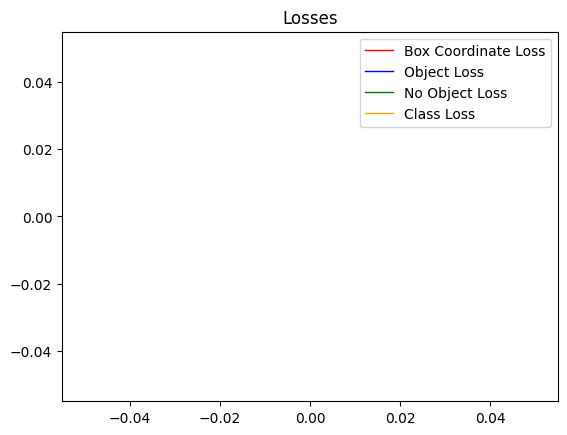

In [170]:
import matplotlib.pyplot as plt

box_coordinate_losses = [loss.item() for loss in loss_fn.box_coordinate_losses]
object_losses = [loss.item() for loss in loss_fn.object_losses]
no_object_losses = [loss.item() for loss in loss_fn.no_object_losses]
class_losses = [loss.item() for loss in loss_fn.class_losses]

plt.plot(range(len(box_coordinate_losses)), box_coordinate_losses, color='red', linestyle='-', linewidth=1, label='Box Coordinate Loss')
plt.plot(range(len(object_losses)), object_losses, color='blue', linestyle='-', linewidth=1, label='Object Loss')
plt.plot(range(len(no_object_losses)), no_object_losses, color='green', linestyle='-', linewidth=1, label='No Object Loss')
plt.plot(range(len(class_losses)), class_losses, color='orange', linestyle='-', linewidth=1, label='Class Loss')

plt.title('Losses')
plt.legend()

plt.show()

<img src="./losses.png" width="700" height="600">

## Example With Our Fruit Model

In [62]:
model = YoloV1(split_size=7, num_boxes=2, num_classes=3).to(DEVICE)
optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1, patience=3, mode='max', verbose=True)

checkpoint = torch.load(LOAD_MODEL_FILE)

model.load_state_dict(checkpoint["state_dict"])
optimizer.load_state_dict(checkpoint["optimizer"])

/Users/benjaminwilen/deep-learning/GHW_DeepLearningProject/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


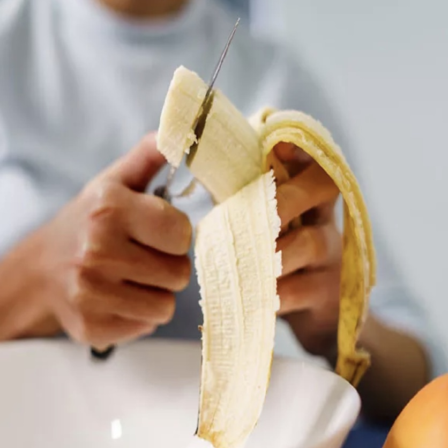

In [159]:
EXAMPLE_IMAGE = "./banana.jpg"
image = Image.open(EXAMPLE_IMAGE)
image = image.convert("RGB")

resize = transforms.Resize((448, 448))
to_tensor = transforms.ToTensor() #transform into correct dimensions

image = resize(image)
image = to_tensor(image)
to_pil = transforms.ToPILImage()
image = image.unsqueeze(0)
display(to_pil(image[0]))

In [161]:

model.eval()

with torch.no_grad():
    predictions = model(image)
bboxes = cellboxes_to_boxes(predictions)

bboxes = non_max_suppression(
                bboxes[0],
                iou_threshold=0.5,
                threshold=0.4,
                box_format="midpoint",
            )


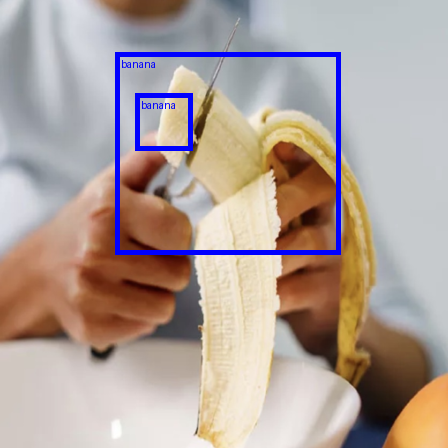

In [167]:
from torchvision.utils import draw_bounding_boxes
int_image = (image[0] * 255).to(torch.uint8)

LABEL_DICT = ['apple', 'banana','orange']
labels = []
boxes = []
for box in bboxes:
    centerx = box[2]
    centery = box[3]
    boxwidth = box[4]
    boxheight = box[5]
    xmin = (centerx * 448) - ((boxwidth * 448) / 2)
    xmax = (centerx * 448) + ((boxwidth * 448) / 2)
    ymin = (centery * 448) - ((boxheight * 448) / 2)
    ymax = (centery * 448) + ((boxheight * 448) / 2)

    boxes.append([xmin, ymin, xmax, ymax])
    labels.append(LABEL_DICT[int(box[0])])

boxes = torch.tensor(boxes, dtype=torch.float32)
colors = ["blue", "blue"]
result = draw_bounding_boxes(int_image, boxes, colors=colors, labels=labels, width=5)
to_pil = transforms.ToPILImage()

display(to_pil(result))

# Implementing Yolov8 and fine tuning

The Yolo model is pretrained on the COCO Data Set:
https://cocodataset.org/#home

In [ ]:
from ultralytics import YOLO
from IPython.display import display, Image

model = YOLO("yolov8m.pt")

There are multiple models you can select, just remeber the bigger models will be more acurate in predictions but it will cause the model to be slower, so take into account what may be best for your specific application:

| Classification  | Detection | Segmentation   | Kind |
|-------|-----|------------| ----- |
| yolov8n-cls.pt | yolov8n.pt |	yolov8n-seg.pt |	Nano |
| yolov8s-cls.pt |	yolov8s.pt| yolov8s-seg.pt	| Small |
| yolov8m-cls.pt | yolov8m.pt | yolov8m-seg.pt	| Medium | 
| yolov8l-cls.pt | yolov8l.pt |	yolov8l-seg.pt	| Large |
| yolov8x-cls.pt | yolov8x.pt |	yolov8x-seg.pt	| Huge |

